# Sonification of Bleeding with Bank of Filters

First Meeting (2019-06-11, Sasan and Thomas) @CITEC, TH proposed Filter-bank for feature generation
* The idea is to use a bank of different low-pass filters to create increasingly smooth signals
* these filtered signals serve as source for identifying key moments to anchor sound events
* which then create a multiscale data-driven complex grain structure of the raw instantaneous bleeding data.
* note that the limit of filtering with a cutoff-frequency towards 0 yields the integrated signal.

## Imports

In [1]:
from scipy import signal
import numpy as np
import scipy.interpolate
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import copy

In [2]:
# %matplotlib inline

## Load Data and Create Filter-Bank Signals

In [3]:
df = pd.read_csv('log_refactored_correction_factor.csv', na_values=['no info', '.'], delimiter=',')
df_indexed = df.reset_index(drop=False)
index = df_indexed['index']
delta = df_indexed['Delta']
volume = df_indexed['Blood Accumulated']

delta_min = delta.min()
delta_max = delta.max()

volume_min = volume.min()
volume_max = volume.max()

print("dataset loaded:")
print(f"  delta:   min={delta_min:8}, max={delta_max:8.3}")
print(f"  volume:  min={volume_min:8}, max={volume_max:8}")

dataset loaded:
  delta:   min=     0.0, max=    8.59
  volume:  min=     0.0, max=  255.75


In [4]:
dfn = scipy.interpolate.interp1d(index, delta) #'previous')
delta_resampled = dfn(np.linspace(0, len(index)-1, len(index)*20))
#plt.plot(delta_resampled, "r.-")

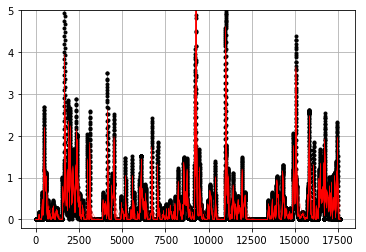

In [5]:
srcsig = delta_resampled
N = srcsig.shape[0]
NF = 15  # number of filters to use
sr = 20
dsf = np.zeros((N, NF))
cfs = np.array(1+np.arange(NF))/(3*NF)  # To do: experiment with exponentially tuned filter frequencies
order = 1 # 2... create oscillations into negative...

for i, cf in enumerate(cfs):
    b, a = signal.butter(order, cf, fs=sr)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, srcsig, zi = zi*delta[0])
    dsf[:, i] = copy.copy(z)

# plot the data
#fig = plt.figure(figsize=(15,4))
plt.plot(srcsig, 'k.-', lw=0.2)
plt.plot(dsf, color='r', lw=0.3);
plt.ylim(-0.2,5); 
#plt.xlim(0,60*sr); 
plt.grid()

In [6]:
# plt.hist(srcsig, 80)
# plt.semilogy()

## Event-based Sonification of filtered data (min/max/threshold cut-throughs...)

In [7]:
import sc3nb as scn
import time
sc = scn.startup()

<IPython.core.display.Javascript object>

Starting sclang...
Done.
Registering UDP callback...
Done.
Booting server...
Done.
-> sc3nb started


In [8]:
# %sc FreqScope(400, 300)

In [9]:
%%sc
~out = 0;
~delta = 0; ~volume = 0;
~volumeMin = 0; ~volumeMax = 0;
("global variables are initialized").postln;

In [10]:
%%scv
SynthDef("pb-sasan", {|out=0, bufnum=0, rate=1, pan=0, amp=0.3, rel=0.1, dur=0.2|
    //var sig1 = PlayBuf.ar(1, bufnum, 1.01*rate * BufRateScale.kr(bufnum), doneAction: 2);
    //var sig2 = PlayBuf.ar(1, bufnum, 0.99*rate * BufRateScale.kr(bufnum), doneAction: 2);

    var drate = SinOsc.ar(3, add:rate * BufRateScale.kr(bufnum), mul:0.01);
    var sig = PlayBuf.ar(1, bufnum, drate, doneAction: 2);

    var env = EnvGen.kr(Env.new([1,1,0], [dur-rel, rel]), doneAction: 2);
    Out.ar(out, Pan2.ar(sig, pan, amp*env))
}).add();

SynthDef(\bpfsaw, {
    arg atk=2, sus=0, rel=3, c1=1, c2=(-1),
    freq=500, detune=0.2, pan=0, cfhzmin=0.1, cfhzmax=0.3,
    cfmin=500, cfmax=2000, rqmin=0.1, rqmax=0.2,
    lsf=200, ldb=0, amp=1, out=0;
    var sig, env;
    env = EnvGen.kr(Env([0,1,1,0],[atk,sus,rel],[c1,0,c2]),doneAction:2);
    sig = Saw.ar(freq * {LFNoise1.kr(0.5,detune).midiratio}!2);
    sig = BPF.ar(
        sig,
        {LFNoise1.kr(
            LFNoise1.kr(4).exprange(cfhzmin,cfhzmax)
        ).exprange(cfmin,cfmax)}!2,
        {LFNoise1.kr(0.1).exprange(rqmin,rqmax)}!2
    );
    sig = BLowShelf.ar(sig, lsf, 0.5, ldb);
    sig = Balance2.ar(sig[0], sig[1], pan);
    sig = sig * env * amp;
    Out.ar(out, sig);
}).add;

SynthDef(\bpfsine, {
    arg atk=2, sus=0, rel=3, c1=1, c2=(-1),
    freq=500, detune=0.2, pan=0, cfhzmin=0.1, cfhzmax=0.3,
    cfmin=500, cfmax=2000, rqmin=0.1, rqmax=0.2,
    lsf=200, ldb=0, amp=1, out=0;
    var sig, env;
    env = EnvGen.kr(Env([0,1,1,0],[atk,sus,rel],[c1,0,c2]),doneAction:2);
    sig = SinOsc.ar(freq * {LFNoise1.kr(0.5,detune).midiratio}!2);
    sig = BPF.ar(
        sig,
        {LFNoise1.kr(
            LFNoise1.kr(4).exprange(cfhzmin,cfhzmax)
        ).exprange(cfmin,cfmax)}!2,
        {LFNoise1.kr(0.1).exprange(rqmin,rqmax)}!2
    );
    sig = BLowShelf.ar(sig, lsf, 0.5, ldb);
    sig = Balance2.ar(sig[0], sig[1], pan);
    sig = sig * env * amp;
    Out.ar(out, sig);
}).add;

SynthDef(\reverb, {
    arg in, predelay=0.1, revtime=1.8,
    lpf=4500, mix=0.15, amp=1, out=0;
    var dry, wet, temp, sig;
    dry = In.ar(in,2);
    temp = In.ar(in,2);
    wet = 0;
    temp = DelayN.ar(temp, 0,2, predelay);
    16.do{
        temp = AllpassN.ar(temp, 0.05, {Rand(0.001,0.05)}!2, revtime);
        temp = LPF.ar(temp, lpf);
        wet = wet + temp;
    };
    sig = XFade2.ar(dry, wet, mix*2-1, amp);
    Out.ar(out, sig);
}).add;

"SynthDefs loaded".postln;

SynthDefs loaded
-> SynthDefs loaded


In [11]:
%%scv
~bus = Dictionary.new;
~bus.add(\reverb -> Bus.audio(s,2));
"Bus loaded".postln;

Bus loaded
-> Bus loaded


In [12]:
%%scv
~mainGroup = Group.new;
~reverbGroup = Group.after(~mainGroup);
~reverbSynth = Synth.new(\reverb, [
        \amp, 1,
        \predelay, 0.4,
        \revtime, 1.8,
        \lpf, 4500,
        \mix, 0.5,
        \in, ~bus[\reverb],
        \out, ~out,
    ], ~reverbGroup
);
"Reverb loaded".postln;

Reverb loaded
-> Reverb loaded


In [33]:
%%scv
e = Dictionary.new;

e.add(\pad_sine_lf -> {
    ~chords = Pbind(
        \instrument, \bpfsine,
        \dur, Pwhite(),
//        \dur, Pwhite(Pfunc{~paddur_min}, Pfunc{~paddur_max}),

        \midinote, Pxrand([
            [23,35,54,63,64],
            [45,52,54,59,61,64],
            [28,40,47,56,59,63],
            [42,52,57,61,63]
        ], inf),
        \detune, Pexprand(0.05,0.2),
        \cfmin, 500,
        \cfmax, 1000,
        \rqmin, Pexprand(0.01,0.02),
        \rqmax, Pexprand(0.2,0.3),
        \atk, Pwhite(2.0,2.5),
        \rel, Pwhite(6.5,10.0),
        \ldb, 6,
        \amp, 0.3,
        \group, ~mainGroup,
        \out, ~bus[\reverb],
    ).play;

    ~marimba = Pbind(
        \instrument, \bpfsaw,
        \dur, Pwhite(Pfunc{~delta.linlin(0,1,0.99,0.05)},
            Pfunc{~delta.linlin(0,1,1,0.1)}),
        \freq, Prand([1/2,2/3,1]*(~delta.explin(0,1,1,4)),inf),
        \detune, Pfunc({~delta.linlin(0,1,0,2)}),
        \rqmin, Pfunc{~volume.linlin(0,1,0.005,0.09)},
        \rqmax, Pfunc{~volume.linlin(0,1,0.008,0.2)},
        \cfmin, Prand((Scale.major.degrees+64).midicps,inf) *
        (Prand(([1,2,4]), inf) * round((Pfunc{~delta.linlin(0,1,1,5)}))),
        \cfmax, Pkey(\cfmin) * Pwhite(1.008,1.025),
        \atk, Pfunc{~volume.linlin(0,1,3,1.5)},
        \sus, Pfunc{~volume.linlin(0,1,1,0.5)},
        \rel, Pfunc{~volume.linlin(0,1,5,2.5)},
        \amp, Pfunc{~amp},
        \pan, Pwhite(Pfunc{~delta.linlin(0,1,0,-1)},Pfunc{~delta}),
        \group, ~mainGroup,
        \out, ~bus[\reverb],
    ).play;
});
e.add(\event_stop -> {
    ~chords.stop;
    ~marimba.stop;
});
"Events loaded".postln;

Events loaded
-> Events loaded
1 568.5197243583341
1 448.29202037351445


In [27]:
%scv 10.linlin(0, 3, 100, 300, \none)

-> 766.66666666667


## User Interfaces

In [14]:
import ipywidgets
import os
import threading
from IPython.display import clear_output

In [15]:
class Bloodplayer:
    
    def __init__(self, data, pulse_time=1, verbose=False):
        self.lock = threading.Lock()
        self.stopevent = threading.Event()
        self.callback_fn = None
        self.idx = 0
        self.data = data
        self.length = data.shape[0]
        self.verbose = verbose
        self.pulse_time = pulse_time
        
    #def __del__():
        # close plot window
        #pass
    
    def callback_fn_default(self, v):
        os.write(1, f"\r                       \r{v}".encode())
        
    def procfn(self):
        self.idx = 0
        while not self.stopevent.wait(0) and self.idx < self.length-1:
            v = self.data[self.idx]
            if self.verbose: 
                os.write(1, f"\r{self.idx}:{self.idx}                   ".encode())
            if callable(self.callback_fn):
                self.callback_fn(self)
            else:
                self.callback_fn_default(v)
            self.idx += 1
            time.sleep(self.pulse_time)
        print("done.")
    
    def set_callback(self, fn):
        self.callback_fn = fn
        
    def create_thread(self):
        threadname = "BloodPlayer-thread"
        # check first if it already exists
        if threadname in [t.name for t in threading.enumerate()]:
            print("create_thread: thread is already existing, stop first")
        else:
            self.stopevent.clear()
            self.producer = threading.Thread(name=threadname, target=self.procfn, args=[])
            self.producer.start()

    def stop_thread(self):
        self.stopevent.set()

In [16]:
bloodplayer = Bloodplayer(delta)

In [17]:
# Plot Data 
%matplotlib

# create figure
fig, ax = plt.subplots(1)  # create figure
mngr = plt.get_current_fig_manager(); 
mngr.window.setGeometry(1200, 0, 500, 400)

# create axis, plots
ax.clear()
plmarked, = ax.plot([], [], "r-", lw=1)
#pldata, = ax.plot(dsf[:,0], "-", ms=2) # create plots
pldata, = ax.plot(delta, "-", ms=2)

def update_plot(t): 
    global fig, ax, plmarked, pldata
    plmarked.set_data([t,t], [-10, 10])
    ax.draw_artist(ax.patch)
    ax.draw_artist(pldata)
    ax.draw_artist(plmarked)
    fig.canvas.update()

def onclick(event):
    global bloodplayer
    if event.dblclick:
        print(event.button, event.xdata)
        bloodplayer.idx = int(event.xdata)

connection_id = fig.canvas.mpl_connect('button_press_event', onclick)

# test with 
# update_plot(5000)

Using matplotlib backend: Qt5Agg


In [18]:
# GUI
def start(b):
    global bloodplayer
    bloodplayer.create_thread()
    %sc e[\pad_sine_lf].value;
    print("start")
b1 = ipywidgets.Button(description='Start') 
b1.on_click(start)

def stop(b):
    global bloodplayer
    print("stop")
    bloodplayer.stop_thread()
    %sc e[\event_stop].value;~init.value;

b2 = ipywidgets.Button(description='Stop') 
b2.on_click(stop)
out = ipywidgets.Output()
ipywidgets.HBox([b1, b2, out])

start
1 452.47538200339557
stop
done.
start
1 456.6411664835713
done.


In [34]:
# Custom code for sonifications
%sc ~mamp = 0
%sc ~paddur_min = 0
%sc ~paddur_max = 0

def son_waterdrop(self):
    # assign delta and volume
    delta_val = delta[self.idx]
    volume_val = volume[self.idx]
        
    # normalize delta and volume
    nd = scn.linlin(delta_val, delta_min, delta_max, 0, 1);        
    nv = scn.linlin(volume_val, volume_min, volume_max, 0, 1);
    
    # set reverb based on normalized values of delta and volume
    revtime = scn.linlin(nv, 0, 1, 1.8, 0.5)
    mix = scn.linlin(nv, 0, 1, 0.5, 0.1)
    predelay = scn.linlin(nv, 0, 1, 0.4, 0.1)
    amp = scn.linlin(nv, 0, 1, 0.8, 0.2)        
    
    mamp = scn.linlin(nd, 0, 0.05, 0.1, 1) 
    %sc ~mamp = ^mamp
    %sc ~delta = ^nd
    %sc ~volume = ^nv
    %sc ~reverbSynth.set(\revtime, ^revtime, \mix, ^mix, \predelay, ^predelay, \amp, ^amp)        

    os.write(1, f"\r{self.idx}:callback{self.idx}                   ".encode())
    update_plot(self.idx)

bloodplayer.set_callback(son_waterdrop)